# Comparing Trading Strategies

TODO: write up about project

Notes on installation?
https://github.com/stefan-jansen/machine-learning-for-trading/tree/main/installation

### Import libraries

In [45]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import zipline

%load_ext zipline
%matplotlib inline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


### Download stock data

In [12]:
start_date='2011-01-01'
end_date='2021-11-06'

def download_stock_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    df = df.reset_index()
    df = df.drop(['Adj Close'], axis=1)
    df = df.rename(str.lower, axis='columns')
    df['dividend'] = 0
    df['split'] = 1
    return df

df_tsla = download_stock_data('TSLA', start_date, end_date)
df_aapl = download_stock_data('AAPL', start_date, end_date)
df_nflx = download_stock_data('NFLX', start_date, end_date)
df_hsbc = download_stock_data('HSBC', start_date, end_date)
df_gs = download_stock_data('GS', start_date, end_date)
df_gme = download_stock_data('GME', start_date, end_date)
df_ge = download_stock_data('GE', start_date, end_date)
df_lyg = download_stock_data('LYG', start_date, end_date)
df_shldq = download_stock_data('SHLDQ', start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Save data to CSV file
Note: the CSV file must be the ticker symbol without additional text like tsla-2011.csv

In [ ]:
df_tsla.to_csv('daily/tsla.csv', index=False)
df_aapl.to_csv('daily/aapl.csv', index=False)
df_nflx.to_csv('daily/nflx.csv', index=False)
df_hsbc.to_csv('daily/hsbc.csv', index=False)
df_gs.to_csv('daily/gs.csv', index=False)
df_gme.to_csv('daily/gme.csv', index=False)
df_ge.to_csv('daily/ge.csv', index=False)
df_lyg.to_csv('daily/lyg.csv', index=False)
df_shldq.to_csv('daily/shldq.csv', index=False)

### Ingest data
Edit ~/.zipline/extension.py according to zipline docs https://zipline.ml4trading.io/bundles.html#ingesting-data-from-csv-files

In [10]:
!zipline ingest -b stocks-2011-2021

[2021-11-08 02:36:32.716123] INFO: zipline.data.bundles.core: Ingesting shldq-2020.
Loading custom pricing data:   [------------------------------------]    0% | aapl: sid 0
Loading custom pricing data:   [####--------------------------------]   11% | ge: sid 1
Loading custom pricing data:   [########----------------------------]   22% | gme: sid 2
Loading custom pricing data:   [############------------------------]   33% | gs: sid 3
Loading custom pricing data:   [################--------------------]   44% | hsbc: sid 4
Loading custom pricing data:   [####################----------------]   55% | lyg: sid 5
Loading custom pricing data:   [########################------------]   66% | nflx: sid 6
Loading custom pricing data:   [############################--------]   77% | shldq: sid 7
Loading custom pricing data:   [################################----]   88% | tsla: sid 8
Loading custom pricing data:   [####################################]  100%
Merging daily equity files:  [#####

In [31]:
!zipline bundles

csvdir <no ingestions>
quandl 2021-10-29 00:52:00.736804
quandl 2021-10-29 00:42:42.964339
quandl 2021-10-28 00:23:28.895431
quantopian-quandl <no ingestions>
stocks-2011-2021 2021-11-11 01:21:14.935265


## Backtesting Trading Strategies
Code from https://towardsdatascience.com/algorithmic-trading-based-on-technical-analysis-in-python-80d445dc6943

In [5]:
# plotting function
def plot(title, results, columns_to_plot):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=[16, 9])

    # portfolio value
    results.portfolio_value.plot(ax=ax[0])
    ax[0].set_ylabel('portfolio value in $')

    # asset
    results[columns_to_plot].plot(ax=ax[1])
    ax[1].set_ylabel('price in $')

    # mark transactions
    perf_trans = results.loc[[t != [] for t in results.transactions]]
    buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax[1].plot(buys.index, results.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
    ax[1].plot(sells.index, results.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')
    ax[1].legend()

    # daily returns
    results.returns.plot(ax=ax[2])
    ax[2].set_ylabel('daily returns')

    fig.suptitle(title, fontsize=16)
    plt.legend()
    plt.show()

    print('Final portfolio value (including cash): ${}'.format(np.round(results.portfolio_value[-1], 2)))


### Buy and Hold

In [51]:
# imports
from zipline.api import order_percent, symbol, record
from zipline.finance import commission

# parameters
SELECTED_STOCK = 'AAPL'

def initialize(context):
    context.asset = symbol(SELECTED_STOCK)
    context.has_ordered = False  
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))

def handle_data(context, data):
    
    # trading logic
    if not context.has_ordered:
        order_percent(context.asset, 1)
        context.has_ordered = True
        
    record(price=data.current(context.asset, 'price'))

In [ ]:
zipline run -f algo/aapl_bah.py -b stocks-2011-2021 --start 2011-1-1 --end 2011-12-31 --capital-base 10000.0 -o results/aapl_2011_bah.pickle --no-benchmark 

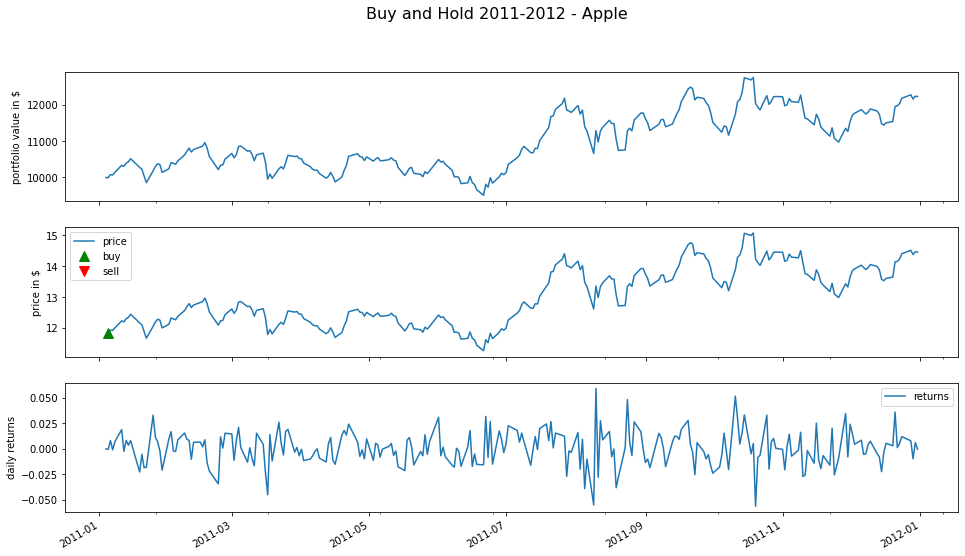

Final portfolio value (including cash): $12229.55


In [54]:
aapl_2011_bah_results = pd.read_pickle('results/aapl_2011_bah.pickle')
plot('Buy and Hold 2011-2012 - Apple', aapl_2011_bah_results, ['price'])

### Simple Moving Average


In [55]:
# imports 
from zipline.api import order_percent, record, symbol, order_target
from zipline.finance import commission

# parameters 
MA_PERIODS = 20
SELECTED_STOCK = 'AAPL'

def initialize(context):
    context.time = 0
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False

def handle_data(context, data):
    context.time += 1
    record(time=context.time)
    if context.time < MA_PERIODS:
        return

    price_history = data.history(context.asset, fields="price", bar_count=MA_PERIODS, frequency="1d")
    ma = price_history.mean()
    
    # cross up
    if (price_history[-2] < ma) & (price_history[-1] > ma) & (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
    # cross down
    elif (price_history[-2] > ma) & (price_history[-1] < ma) & (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False

    record(price=data.current(context.asset, 'price'),
           moving_average=ma)

In [ ]:
zipline run -f algo/aapl_sma.py -b stocks-2011-2021 --start 2011-1-1 --end 2011-12-31 --capital-base 10000.0 -o results/aapl_2011_sma.pickle --no-benchmark 

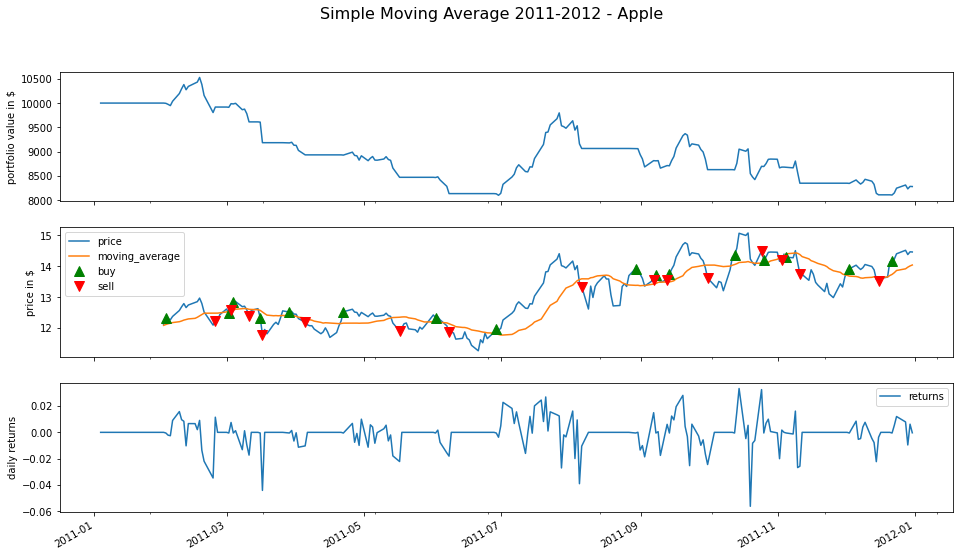

Final portfolio value (including cash): $8280.51


In [56]:
aapl_2011_sma_results = pd.read_pickle('results/aapl_2011_sma.pickle')
plot('Simple Moving Average 2011-2012 - Apple', aapl_2011_sma_results, ['price', 'moving_average'])

### Moving Average Crossover

In [57]:
# imports 
from zipline.api import order_percent, record, symbol, order_target
from zipline.finance import commission

# parameters 
SELECTED_STOCK = 'AAPL'
SLOW_MA_PERIODS = 100
FAST_MA_PERIODS = 20

def initialize(context):
    context.time = 0
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False
    
def handle_data(context, data):
    context.time += 1
    if context.time < SLOW_MA_PERIODS:
        return

    fast_ma = data.history(context.asset, 'price', bar_count=FAST_MA_PERIODS, frequency="1d").mean()
    slow_ma = data.history(context.asset, 'price', bar_count=SLOW_MA_PERIODS, frequency="1d").mean()

    # Trading logic
    if (fast_ma > slow_ma) & (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
    elif (fast_ma < slow_ma) & (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False

    record(price=data.current(context.asset, 'price'),
           fast_ma=fast_ma,
           slow_ma=slow_ma)

In [ ]:
zipline run -f algo/aapl_mac.py -b stocks-2011-2021 --start 2011-1-1 --end 2011-12-31 --capital-base 10000.0 -o results/aapl_2011_mac.pickle --no-benchmark 

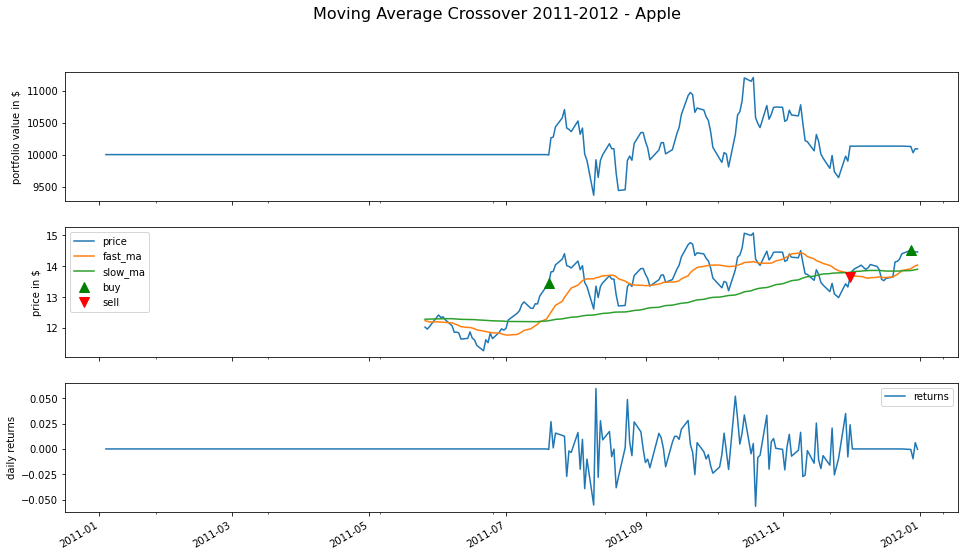

Final portfolio value (including cash): $10089.14


In [58]:
aapl_2011_mac_results = pd.read_pickle('results/aapl_2011_mac.pickle')
plot('Moving Average Crossover 2011-2012 - Apple', aapl_2011_mac_results, ['price', 'fast_ma', 'slow_ma'])

### MACD

In [59]:
# imports ----
from zipline.api import order_target, record, symbol, set_commission, order_percent
import matplotlib.pyplot as plt
import talib as ta
from zipline.finance import commission

# parameters ----
SELECTED_STOCK = 'AAPL'

 #initialize the strategy 
def initialize(context):
    context.time = 0
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False
    
def handle_data(context, data):
    context.time += 1
    if context.time < 34:
        return
    
    price_history = data.history(context.asset, fields="price", bar_count=34, frequency="1d")
    macd, macdsignal, macdhist = ta.MACD(price_history, 12, 26, 9) 
    
    if (macdsignal[-1] < macd[-1]) and (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
        
    if (macdsignal[-1] > macd[-1]) and (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False
        
    record(macd =  macd[-1], macdsignal = macdsignal[-1], macdhist = macdhist[-1], price=price_history[-1])

In [ ]:
zipline run -f algo/aapl_macd.py -b stocks-2011-2021 --start 2011-1-1 --end 2011-12-31 --capital-base 10000.0 -o results/aapl_2011_macd.pickle --no-benchmark 

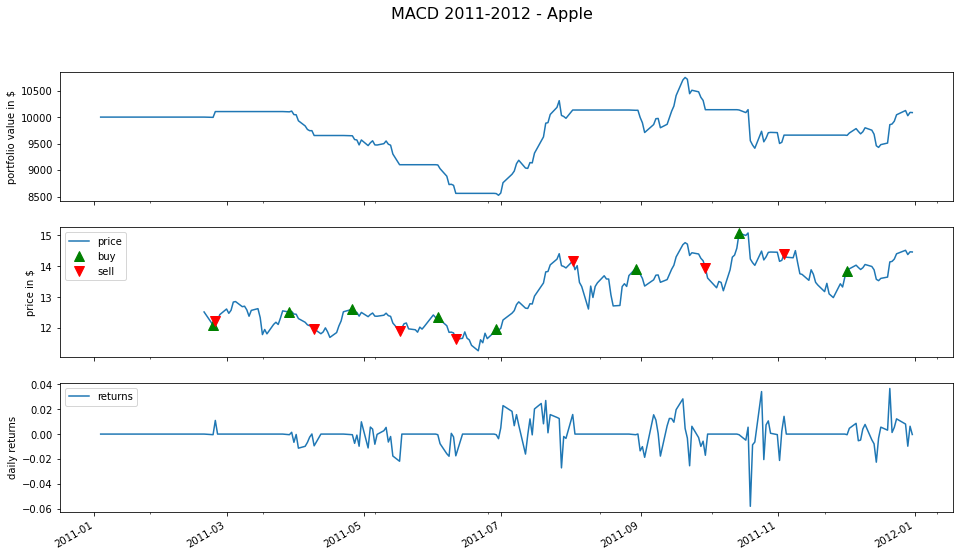

Final portfolio value (including cash): $10085.34


In [60]:
aapl_2011_macd_results = pd.read_pickle('results/aapl_2011_macd.pickle')
plot('MACD 2011-2012 - Apple', aapl_2011_macd_results, ['price'])

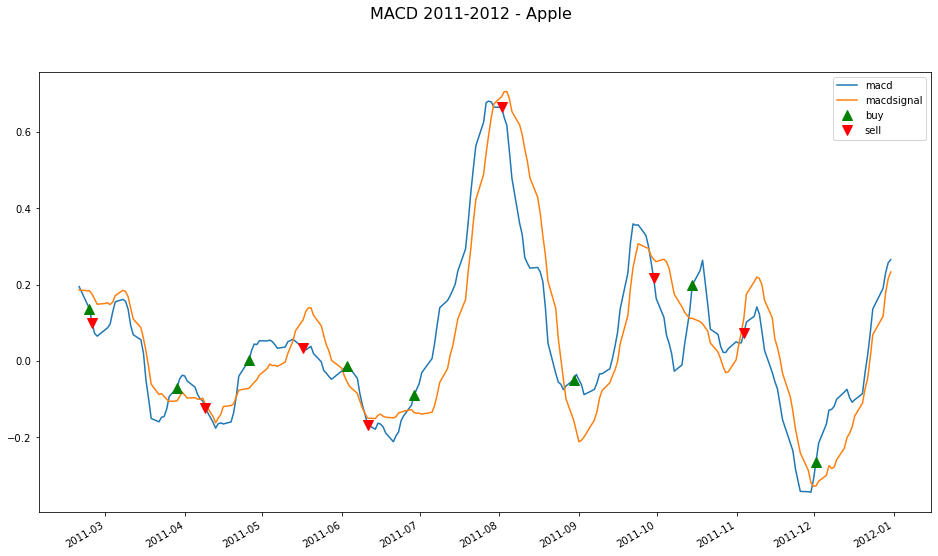

In [64]:
fig, ax = plt.subplots(figsize=[16, 9])

# asset
aapl_2011_macd_results[['macd', 'macdsignal']].plot(ax=ax)

# mark transactions
perf_trans = aapl_2011_macd_results.loc[[t != [] for t in aapl_2011_macd_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax.plot(buys.index, aapl_2011_macd_results.macd.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax.plot(sells.index, aapl_2011_macd_results.macd.loc[sells.index], 'v', markersize=10, color='r', label='sell')
ax.legend()

fig.suptitle('MACD 2011-2012 - Apple', fontsize=16)
plt.show()

### RSI

In [61]:
# imports ----
from zipline.api import order_target, record, symbol, set_commission, order_percent
import matplotlib.pyplot as plt
import talib as ta
from zipline.finance import commission

# parameters ----
SELECTED_STOCK = 'AAPL'
UPPER = 70
LOWER = 30
RSI_PERIOD = 14

 #initialize the strategy 
def initialize(context):
    context.time = 0
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False
    
def handle_data(context, data):
    context.time += 1
    if context.time < RSI_PERIOD + 1:
        return
    
    price_history = data.history(context.asset, fields="price", bar_count=RSI_PERIOD+1, frequency="1d")
    rsi = ta.RSI(price_history, timeperiod=RSI_PERIOD)
    
    if rsi[-1] < LOWER and not context.has_position:
        order_percent(context.asset, 1.0)
        context.has_position = True
      
    if rsi[-1] > UPPER and context.has_position:
        order_target(context.asset, 0)
        context.has_position = False
     
    record(rsi=rsi[-1], price=price_history[-1], time=context.time) 

In [ ]:
zipline run -f algo/aapl_rsi.py -b stocks-2011-2021 --start 2011-1-1 --end 2011-12-31 --capital-base 10000.0 -o results/aapl_2011_rsi.pickle --no-benchmark 

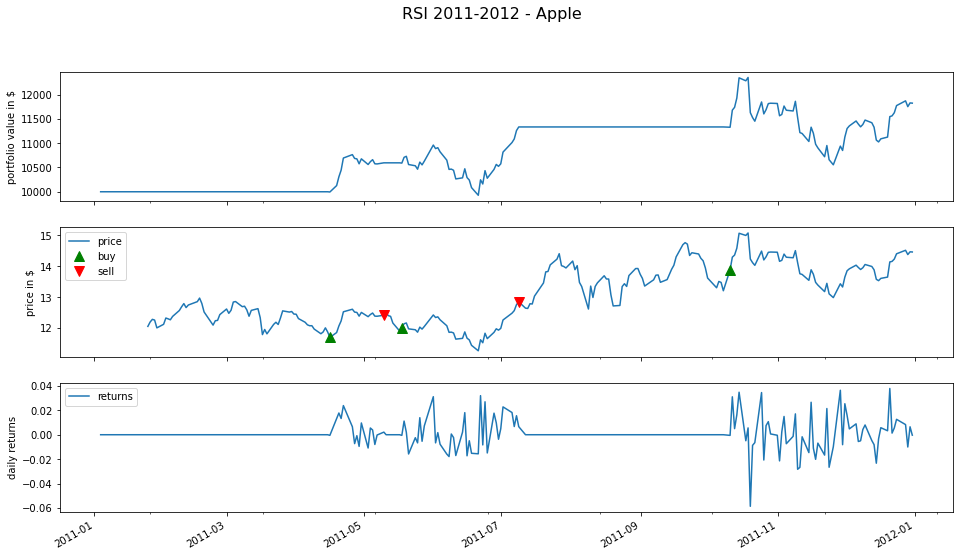

Final portfolio value (including cash): $11823.54


In [62]:
aapl_2011_rsi_results = pd.read_pickle('results/aapl_2011_rsi.pickle')
plot('RSI 2011-2012 - Apple', aapl_2011_rsi_results, ['price'])

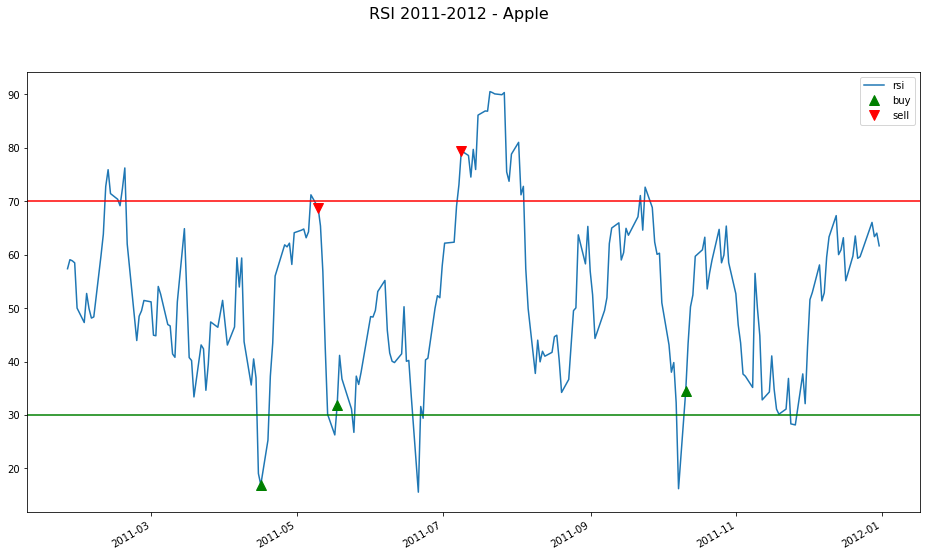

In [65]:
fig, ax = plt.subplots(figsize=[16, 9])

# asset
aapl_2011_rsi_results[['rsi']].plot(ax=ax)
ax.axhline(y=70, color='r')
ax.axhline(y=30, color='g')

# mark transactions
perf_trans = aapl_2011_rsi_results.loc[[t != [] for t in aapl_2011_rsi_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax.plot(buys.index, aapl_2011_rsi_results.rsi.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax.plot(sells.index, aapl_2011_rsi_results.rsi.loc[sells.index], 'v', markersize=10, color='r', label='sell')
ax.legend()

fig.suptitle('RSI 2011-2012 - Apple', fontsize=16)
plt.show()